🚀 Starting Customer Churn Prediction
✅ File loaded successfully.

🔍 Dataset Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   customerID           7043 non-null   object  
 1   gender               7043 non-null   object  
 2   SeniorCitizen        7043 non-null   int64   
 3   Partner              7043 non-null   object  
 4   Dependents           7043 non-null   object  
 5   tenure               7043 non-null   int64   
 6   PhoneService         7043 non-null   object  
 7   MultipleLines        7043 non-null   object  
 8   InternetService      7043 non-null   object  
 9   OnlineSecurity       7043 non-null   object  
 10  OnlineBackup         7043 non-null   object  
 11  DeviceProtection     7043 non-null   object  
 12  TechSupport          7043 non-null   object  
 13  StreamingTV          7043 non-null   o

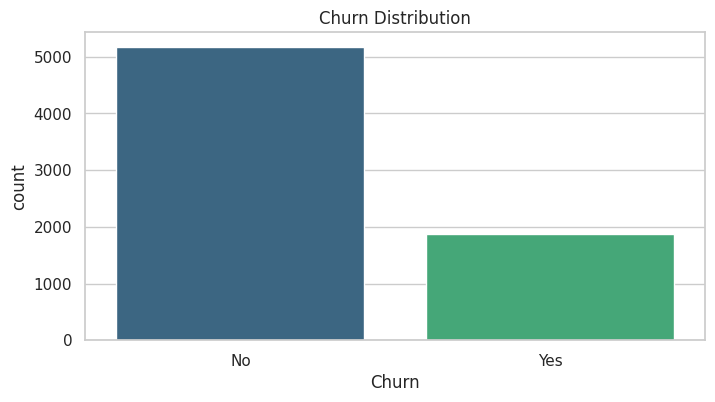

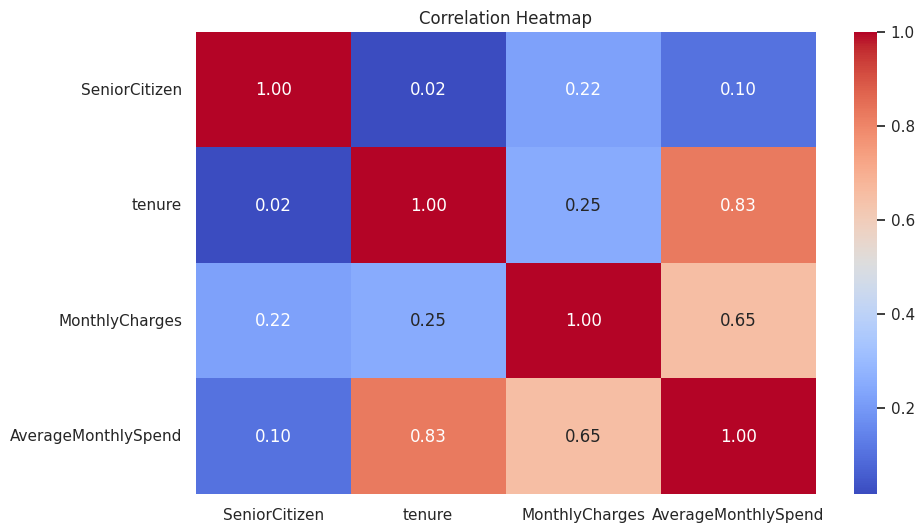


⚙️ Preprocessing data...

🔎 Logistic Regression Performance:
              precision    recall  f1-score   support

          No       0.83      0.90      0.86      1033
         Yes       0.63      0.50      0.56       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407



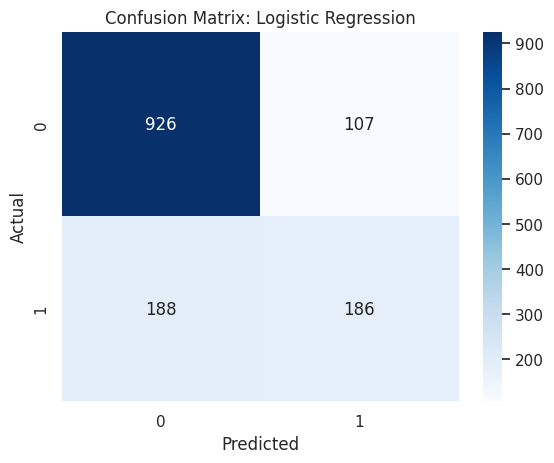


🔎 Decision Tree Performance:
              precision    recall  f1-score   support

          No       0.83      0.81      0.82      1033
         Yes       0.51      0.53      0.52       374

    accuracy                           0.74      1407
   macro avg       0.67      0.67      0.67      1407
weighted avg       0.74      0.74      0.74      1407



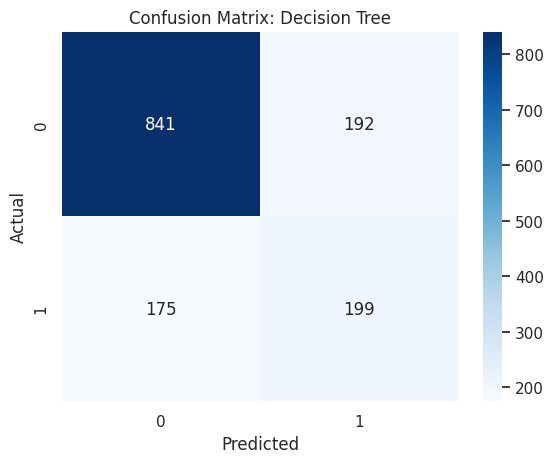


🔎 Random Forest Performance:
              precision    recall  f1-score   support

          No       0.83      0.92      0.87      1033
         Yes       0.67      0.47      0.55       374

    accuracy                           0.80      1407
   macro avg       0.75      0.69      0.71      1407
weighted avg       0.78      0.80      0.78      1407



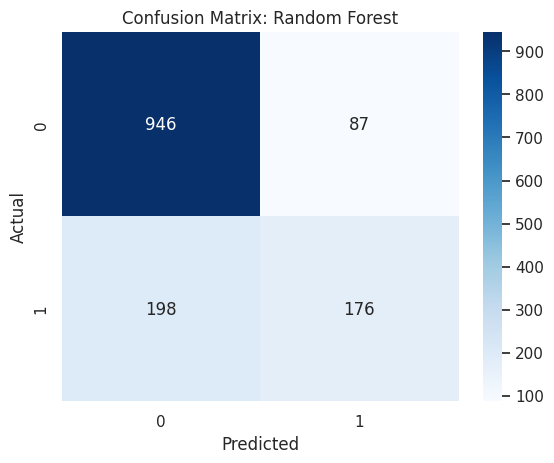


🔎 Gradient Boosting Performance:
              precision    recall  f1-score   support

          No       0.83      0.90      0.86      1033
         Yes       0.63      0.50      0.56       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407



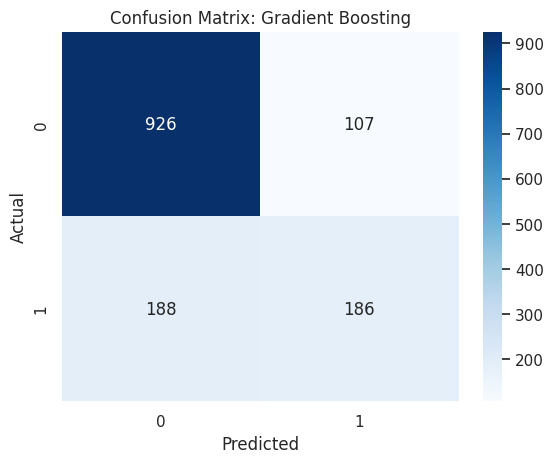


🔧 Tuning Random Forest...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
✅ Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}

✅ Evaluating Best Model:
              precision    recall  f1-score   support

          No       0.83      0.91      0.87      1033
         Yes       0.67      0.49      0.57       374

    accuracy                           0.80      1407
   macro avg       0.75      0.70      0.72      1407
weighted avg       0.79      0.80      0.79      1407


📊 Generating SHAP summary plot...


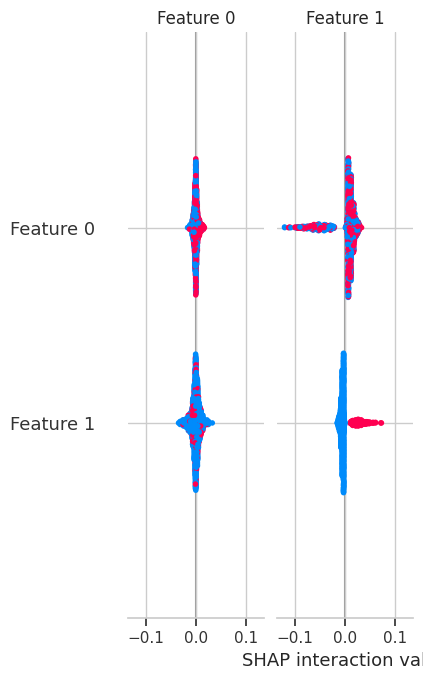


📁 Model saved to `best_random_forest_model.pkl`

🧾 Enter customer details:
gender: Male
SeniorCitizen: 0
Partner: Yes
Dependents: No
tenure: 1
PhoneService: Yes
MultipleLines: Mo
❌ Invalid input for 'MultipleLines'. Allowed values: ['No', 'No phone service', 'Yes']
MultipleLines: No
InternetService: Yes
❌ Invalid input for 'InternetService'. Allowed values: ['DSL', 'Fiber optic', 'No']
InternetService: No
OnlineSecurity: No
OnlineBackup: No
DeviceProtection: No
TechSupport: No
StreamingTV: No
StreamingMovies: No
Contract: Yes
❌ Invalid input for 'Contract'. Allowed values: ['Month-to-month', 'One year', 'Two year']
Contract: Two year
PaperlessBilling: Yes
PaymentMethod: Card
❌ Invalid input for 'PaymentMethod'. Allowed values: ['Bank transfer (automatic)', 'Credit card (automatic)', 'Electronic check', 'Mailed check']
PaymentMethod: Bank transfer (automatic)
MonthlyCharges: 1545.25
TotalCharges: 2585.21
AverageMonthlySpend: 458.21
TenureCategory: 0-1 year

🔮 Predicted Churn: No


In [42]:
import os
import joblib
import shap
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix

sns.set(style='whitegrid')

def load_data(file_path):
    if not os.path.exists(file_path):
        print(f"File not found at: {file_path}")
        return None
    try:
        return pd.read_csv(file_path)
    except Exception as e:
        print(f"Failed to load file: {e}")
        return None

def perform_eda(df):
    print(df.info())
    print(df.describe())

    sns.countplot(x='Churn', data=df, palette='viridis')
    plt.title('Churn Distribution')
    plt.show()

    numeric_cols = df.select_dtypes(include=[np.number])
    sns.heatmap(numeric_cols.corr(), annot=True, fmt=".2f", cmap='coolwarm')
    plt.title('Correlation Heatmap')
    plt.show()

def add_features(df):
    df['AverageMonthlySpend'] = df['MonthlyCharges'] * df['tenure']
    df['TenureCategory'] = pd.cut(
        df['tenure'],
        bins=[0, 12, 24, 36, 48, 60, df['tenure'].max()],
        labels=['0-1 year', '1-2 years', '2-3 years', '3-4 years', '4-5 years', '5-6 years']
    )
    return df

def preprocess(df):
    df = df.copy()
    df.replace(" ", np.nan, inplace=True)
    df.dropna(inplace=True)
    df.drop(['customerID'], axis=1, inplace=True)

    df['TotalCharges'] = df['TotalCharges'].astype(float)

    binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
    for col in binary_cols:
        df[col] = df[col].map({'Yes': 1, 'No': 0})

    df['gender'] = df['gender'].map({'Female': 1, 'Male': 0})

    multicol = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
                'Contract', 'PaymentMethod', 'TenureCategory']
    df = pd.get_dummies(df, columns=multicol)

    return df

def train_model(X_train, y_train):
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    return model

def explain_model(model, X_train):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train)
    shap.summary_plot(shap_values[1], X_train)

def evaluate(model, X_test, y_test):
    predictions = model.predict(X_test)
    print(classification_report(y_test, predictions))
    sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

def save_model(model, path):
    joblib.dump(model, path)
    print(f"Model saved to {path}")

if __name__ == "__main__":
    data_path = "../churn_model/data/Telco-Customer-Churn.csv"
    df = load_data(data_path)

    if df is not None:
        perform_eda(df)
        df = add_features(df)
        df = preprocess(df)

        X = df.drop('Churn', axis=1)
        y = df['Churn']

        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

        model = train_model(X_train, y_train)

        evaluate(model, X_test, y_test)

        save_model(model, "best_random_forest_model.pkl")
